Loaded image with dimensions: 500x500


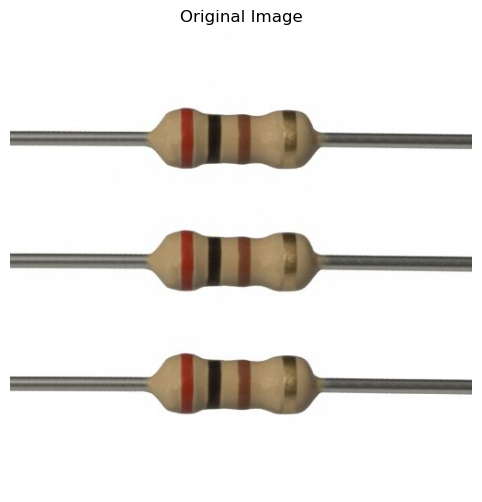

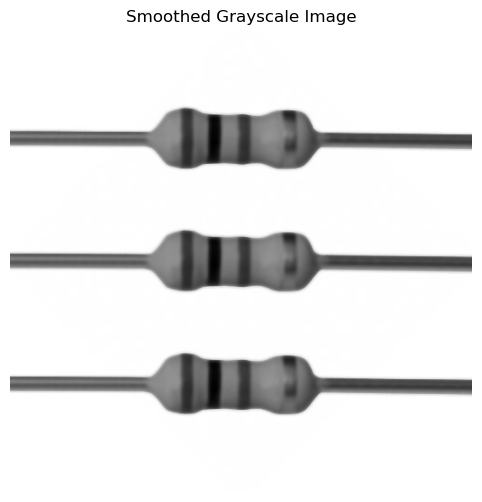

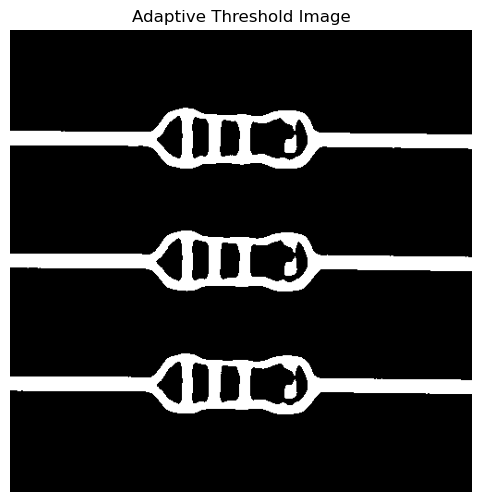

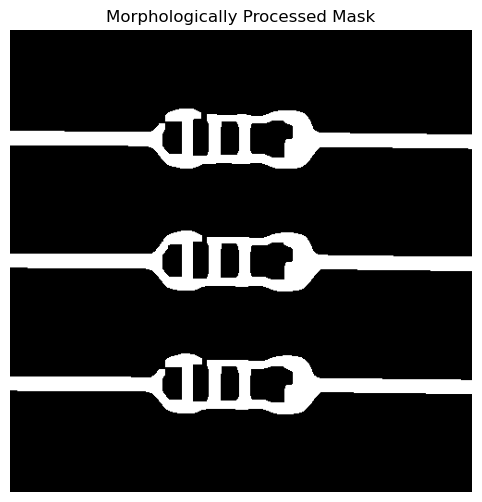

Found 3 initial contours
Have 3 contours after filtering (Area, Aspect Ratio, Color)


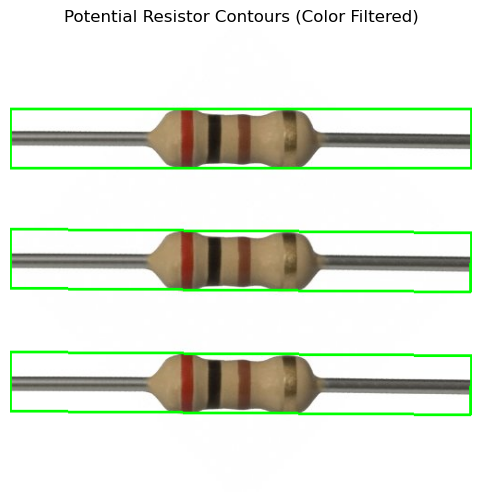

Selected the resistor contour with area: 13508.00
Selected the resistor with color std sum: 228.03
Resistor dimensions (w, h) are: (499.15, 64.14), with Angle: 0.53


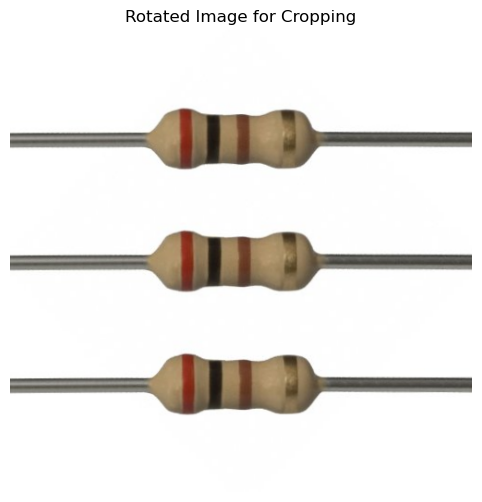

Final cropped size is: 499x64


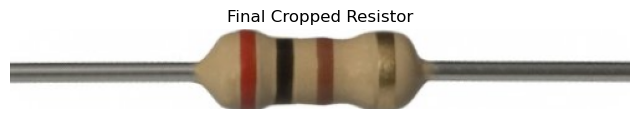

Applying Gamma Correction for Brightening...


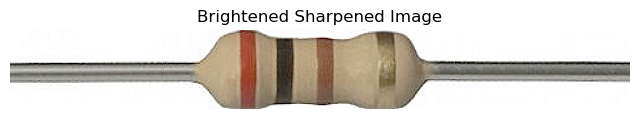

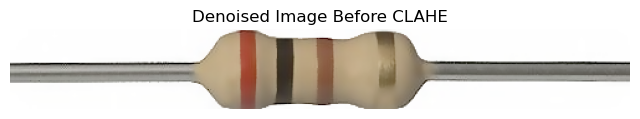

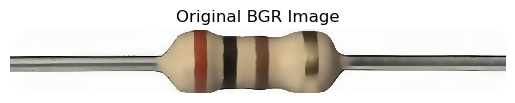

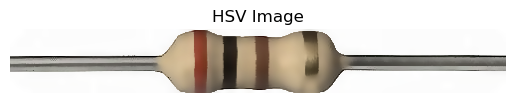

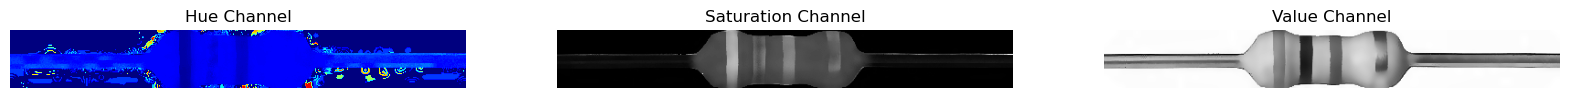

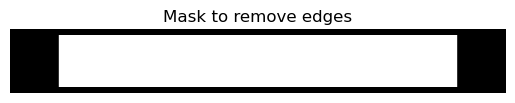

Starting color mask generation and contour analysis...

Processing color: black


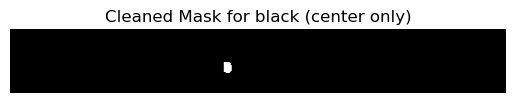

Accepted the black band with confidence: 100.00% at x=215, area=63.5, AR=1.38
Found vertical band contours for black.

Processing color: brown


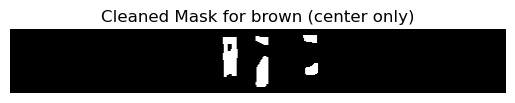

Accepted the brown band with confidence: 97.25% at x=247, area=287.0, AR=2.38
Accepted the brown band with confidence: 97.25% at x=214, area=472.0, AR=2.67
Found vertical band contours for brown.

Processing color: red


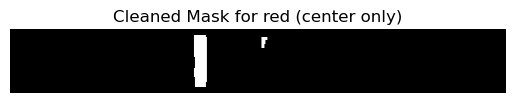

Accepted the red band with confidence: 97.55% at x=253, area=31.0, AR=1.83
Accepted the red band with confidence: 97.55% at x=185, area=585.5, AR=4.00
Found vertical band contours for red.

Processing color: orange


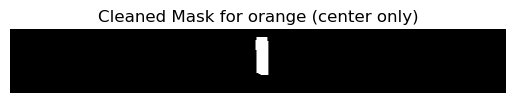

Accepted the orange band with confidence: 97.37% at x=247, area=408.5, AR=2.92
Found vertical band contours for orange.

Processing color: yellow


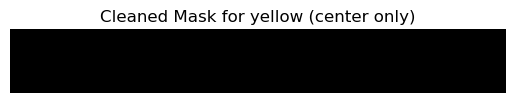

Found vertical band contours for yellow.

Processing color: green


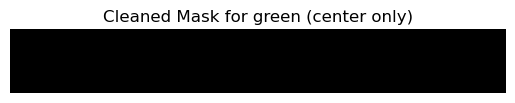

Found vertical band contours for green.

Processing color: blue


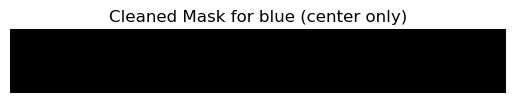

Found vertical band contours for blue.

Processing color: violet


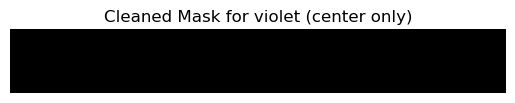

Found vertical band contours for violet.

Processing color: grey


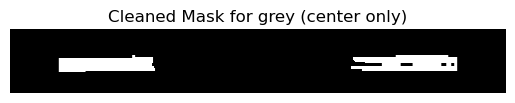

Found vertical band contours for grey.

Processing color: white


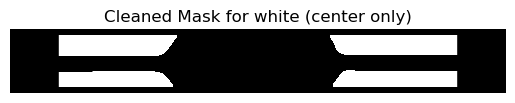

Found vertical band contours for white.

Processing color: gold


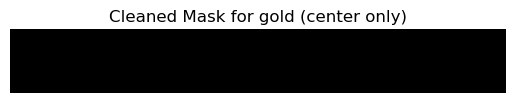

Found vertical band contours for gold.

Processing color: silver


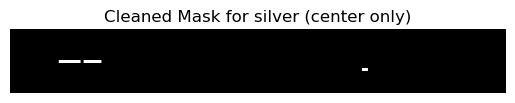

Found vertical band contours for silver.
Finished color mask generation and contour analysis.
Sorted band colors are: ['red', 'brown', 'black', 'brown', 'orange', 'red']
Detected 6 bands. This number of bands is currently unsupported for calculation.


In [59]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math # Import math for calculations

# Parameters (These are the parameters I use)
IMAGE_PATH = 'Training_Data/example2.jpg'
BLUR_DIAMETER = 7
BLUR_SIGMA_COLOR = 100
BLUR_SIGMA_SPACE = 100
ADAPTIVE_BLOCK_SIZE = 51 # Must be odd
ADAPTIVE_C = 9
MORPH_KERNEL_SIZE = (7, 7)
MORPH_CLOSE_ITER = 2
MORPH_OPEN_ITER = 1
MIN_CONTOUR_AREA = 500 # Minimum area to consider a contour
MIN_ASPECT_RATIO = 2.0 # Minimum aspect ratio

# Minimum color variation required for a contour
MIN_COLOR_STD_SUM = 30

def display_image(img, title="Image", cmap=None):
    """Helper function to display images using matplotlib."""
    plt.figure(figsize=(8, 6))
    if cmap:
        plt.imshow(img, cmap=cmap)
    else:
        # Assume BGR from cv2, convert to RGB for matplotlib
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")
    plt.show()

# 1. Load image
img = cv2.imread(IMAGE_PATH)
if img is None:
    raise FileNotFoundError(f"Could not load the image at {IMAGE_PATH}")
img_height, img_width = img.shape[:2]
print(f"Loaded image with dimensions: {img_width}x{img_height}")
display_image(img, "Original Image")

# 2. Grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 3. Smooth the image
smooth = cv2.bilateralFilter(gray, BLUR_DIAMETER, BLUR_SIGMA_COLOR, BLUR_SIGMA_SPACE)
display_image(smooth, "Smoothed Grayscale Image", cmap='gray')

# 4. Adaptive Thresholding
adaptive_binary = cv2.adaptiveThreshold(
    smooth, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY_INV, # Use inverse binary thresholding
    ADAPTIVE_BLOCK_SIZE, ADAPTIVE_C
)
display_image(adaptive_binary, "Adaptive Threshold Image", cmap='gray')

# 5. Morphological Cleanup on the thresholded mask
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, MORPH_KERNEL_SIZE)
closed = cv2.morphologyEx(adaptive_binary, cv2.MORPH_CLOSE, kernel, iterations=MORPH_CLOSE_ITER)
opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel, iterations=MORPH_OPEN_ITER)
processed_mask = opened
display_image(processed_mask, "Morphologically Processed Mask", cmap='gray')

# 6. Contour Detection
contours, hierarchy = cv2.findContours(processed_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print(f"Found {len(contours)} initial contours")

# 7. Filter the detected contours by area, aspect ratio, and color
potential_resistors = []
img_for_contours = img.copy() # Will draw on a copy

for cnt in contours:
    area = cv2.contourArea(cnt)

    # Filter by area
    if area < MIN_CONTOUR_AREA:
        continue

    # Filter by aspect ratio using minAreaRect
    rect = cv2.minAreaRect(cnt)
    (x, y), (width, height), angle = rect

    width = max(1, width) # Ensure dimension is at least 1
    height = max(1, height) # Ensure dimension is at least 1

    aspect_ratio = max(width / height, height / width)

    if aspect_ratio < MIN_ASPECT_RATIO:
        continue

    # Add a new filter for color variation
    # Get the bounding box coordinates
    box_pts = cv2.boxPoints(rect)
    box_pts = np.intp(box_pts) # Convert to integer points

    # Find min/max x and y to define the ROI
    min_x = np.min(box_pts[:, 0])
    max_x = np.max(box_pts[:, 0])
    min_y = np.min(box_pts[:, 1])
    max_y = np.max(box_pts[:, 1])

    # Ensure ROI coordinates are within image bounds
    min_x = max(0, min_x)
    min_y = max(0, min_y)
    max_x = min(img_width, max_x)
    max_y = min(img_height, max_y)

    # Extract the ROI from the ORIGINAL COLOR image
    roi_color = img[min_y:max_y, min_x:max_x]

    if roi_color.size == 0:
        continue # Skip if ROI is invalid

    # Calculate the standard deviation for each color channel (B, G, R)
    # This gives a measure of how much the color varies within the ROI
    std_dev_channels = np.std(roi_color, axis=(0, 1)) # Calculate std dev across height and width
    std_sum = np.sum(std_dev_channels) # Sum the standard deviations across B, G, R channels

    if std_sum < MIN_COLOR_STD_SUM:
        continue # Skip if color variation is too low

    # If a contour passes all filters:
    potential_resistors.append({'contour': cnt, 'rect': rect, 'area': area, 'color_std_sum': std_sum})
    # Draw the accepted contours
    box = cv2.boxPoints(rect)
    box = np.intp(box)
    cv2.drawContours(img_for_contours, [box], 0, (0, 255, 0), 2) # Draw a green box

print(f"Have {len(potential_resistors)} contours after filtering (Area, Aspect Ratio, Color)")
display_image(img_for_contours, "Potential Resistor Contours (Color Filtered)")

# 8. Select the best candidate (the one with the largest area among filtered)
if not potential_resistors:
    raise ValueError("Did not detect any suitable resistor contour after filtering.")

# Sort by area descending and take the largest one
potential_resistors.sort(key=lambda item: item['area'], reverse=True)
best_resistor_data = potential_resistors[0]
resistor_contour = best_resistor_data['contour']
rect = best_resistor_data['rect'] # (center (x,y), (width, height), angle)

print(f"Selected the resistor contour with area: {best_resistor_data['area']:.2f}")
print(f"Selected the resistor with color std sum: {best_resistor_data['color_std_sum']:.2f}")

# 9. Determine the rotation angle
center, size, angle = rect
resistor_width, resistor_height = size

if resistor_height > resistor_width:
    angle += 90
    resistor_width, resistor_height = resistor_height, resistor_width

print(f"Resistor dimensions (w, h) are: ({resistor_width:.2f}, {resistor_height:.2f}), with Angle: {angle:.2f}")

# 10. Rotate the original image
rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
rotated_img = cv2.warpAffine(img, rotation_matrix, (img_width, img_height), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE)
display_image(rotated_img, "Rotated Image for Cropping")

# 11. Crop the rotated image
crop_width = int(resistor_width)
crop_height = int(resistor_height)
crop_center_x, crop_center_y = center

crop_x = int(crop_center_x - crop_width / 2)
crop_y = int(crop_center_y - crop_height / 2)

crop_x = max(0, crop_x)
crop_y = max(0, crop_y)
if crop_x + crop_width > img_width:
    crop_width = img_width - crop_x
if crop_y + crop_height > img_height:
    crop_height = img_height - crop_y

cropped_resistor = rotated_img[crop_y : crop_y + crop_height, crop_x : crop_x + crop_width]

if cropped_resistor.size == 0:
    print("Error: Cropped resistor area is empty! Need to check parameters or rotation.")
    print(f"Calculated the crop region: x={crop_x}, y={crop_y}, w={crop_width}, h={crop_height}")
else:
    print(f"Final cropped size is: {cropped_resistor.shape[1]}x{cropped_resistor.shape[0]}")
    display_image(cropped_resistor, "Final Cropped Resistor")

# Sharpen the image
sharpen_kernel = np.array([
    [0, -1, 0],
    [-1, 5,-1],
    [0, -1, 0]
])
sharpened = cv2.filter2D(cropped_resistor, -1, sharpen_kernel)

print("Applying Gamma Correction for Brightening...")
gamma = 0.7 # Use this value to control brightness. Smaller values brighten more.
lookUpTable = np.array([((i / 255.0) ** gamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
brightened_sharpened = cv2.LUT(sharpened, lookUpTable)
display_image(brightened_sharpened, "Brightened Sharpened Image")

# Apply denoising before CLAHE
denoised_before_clahe = cv2.bilateralFilter(brightened_sharpened, d=9, sigmaColor=75, sigmaSpace=75)
display_image(denoised_before_clahe, "Denoised Image Before CLAHE")

# Apply CLAHE for more vibrant colors
hsv_sharp = cv2.cvtColor(denoised_before_clahe, cv2.COLOR_BGR2HSV)
h, s, v = cv2.split(hsv_sharp)

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4,4)) # Set these parameters for CLAHE
v_clahe = clahe.apply(v)

enhanced_hsv = cv2.merge((h, s, v_clahe))
vibrant_resistor = cv2.cvtColor(enhanced_hsv, cv2.COLOR_HSV2BGR)

# Apply final denoising
vibrant_resistor = cv2.bilateralFilter(vibrant_resistor, 9, 75, 75)

# Start the color classification process to find resistor bands
plt.imshow(cv2.cvtColor(vibrant_resistor, cv2.COLOR_BGR2RGB))
plt.title("Original BGR Image")
plt.axis("off")
plt.show()

# Convert to HSV for color segmentation
img_hsv = cv2.cvtColor(vibrant_resistor, cv2.COLOR_BGR2HSV)
plt.imshow(cv2.cvtColor(img_hsv, cv2.COLOR_HSV2RGB))
plt.title("HSV Image")
plt.axis("off")
plt.show()

h, s, v = cv2.split(img_hsv)

h_normalized = (h * 255 / 179).astype(np.uint8)

fig, axes = plt.subplots(1, 3, figsize=(20, 5))
axes[0].imshow(h, cmap="jet"), axes[0].set_title("Hue Channel"), axes[0].axis("off")
axes[1].imshow(s, cmap="gray"), axes[1].set_title("Saturation Channel"), axes[1].axis("off")
axes[2].imshow(v, cmap="gray"), axes[2].set_title("Value Channel"), axes[2].axis("off")

plt.show()

# HSV color ranges for resistor bands (H: 0-180, S: 0-255, V: 0-255)
color_ranges = {
    'black': [(np.array([0, 0, 0]), np.array([180, 255, 30]))], # Covers very low Value
    'brown': [
        (np.array([5, 100, 20]), np.array([20, 255, 100])), # Range for reddish-brown
        (np.array([10, 80, 20]), np.array([30, 255, 100]))  # Range for orangeish-brown
    ],
    'red': [
        (np.array([0, 100, 60]), np.array([10, 255, 255])),    # Lower H range for red
        (np.array([170, 100, 60]), np.array([180, 255, 255])) # Upper H range for red
    ],
    'orange': [(np.array([10, 120, 80]), np.array([20, 255, 255]))], # Orange range
    'yellow': [(np.array([20, 140, 80]), np.array([50, 255, 255]))], # Yellow range
    'green': [(np.array([40, 80, 30]), np.array([80, 255, 255]))], # Green range
    'blue': [(np.array([85, 80, 40]), np.array([130, 255, 255]))], # Blue range
    'violet': [(np.array([130, 30, 30]), np.array([160, 255, 255]))], # Violet range
    'grey': [(np.array([0, 0, 75]), np.array([180, 20, 200]))], # Low Saturation, mid Value
    'white': [(np.array([0, 0, 225]), np.array([180, 20, 255]))], # Low Saturation, high Value
    'gold': [(np.array([10, 200, 30]), np.array([32, 255, 180]))], # Gold range
    'silver': [(np.array([0, 0, 180]), np.array([180, 15, 240]))] # Low Saturation, higher Value
}

height, width = img_hsv.shape[:2]
# Create a binary mask with 1s in the middle, 0s on borders
resistor_mask = np.zeros((height, width), dtype=np.uint8)
cv2.rectangle(resistor_mask, (int(0.1*width), int(0.1*height)), (int(0.9*width), int(0.9*height)), 255, -1)
plt.imshow(resistor_mask, cmap="gray")
plt.title("Mask to remove edges")
plt.axis("off")
plt.show()

kernel = np.ones((3, 3), np.uint8) # Define a kernel for morphological operations

def calculate_confidence(masked_region, hsv_image, ranges_list):
    # This function calculates the confidence score for a region matching color ranges.

    if not ranges_list:
        return 0.0 # Return 0 confidence if no ranges are provided

    # Create an initial empty mask
    combined_mask = np.zeros_like(masked_region, dtype=np.uint8)

    # Iterate through each color range and combine the masks
    for lower_hsv, upper_hsv in ranges_list:
        # Ensure bounds are numpy arrays
        lower_bound = np.array(lower_hsv)
        upper_bound = np.array(upper_hsv)

        # Create a mask for the current color range
        color_mask = cv2.inRange(hsv_image, lower_bound, upper_bound)

        # Combine the current mask with the overall combined mask using bitwise OR
        combined_mask = cv2.bitwise_or(combined_mask, color_mask)

    # Count pixels within the combined color mask and the masked region
    matched_pixels = np.sum(np.bitwise_and(masked_region, combined_mask) > 0)

    # Count total pixels in the masked region
    total_region_pixels = np.sum(masked_region > 0)

    if total_region_pixels == 0:
        return 0.0 # Avoid division by zero

    # Calculate confidence
    confidence = (matched_pixels / total_region_pixels) * 100
    return confidence

# Initialize the list to store information about detected bands
band_info = []

print("Starting color mask generation and contour analysis...")

# Loop through each color and its list of ranges
for color_name, ranges_list in color_ranges.items():
    print(f"\nProcessing color: {color_name}")

    # Initialize an empty mask for this color
    color_mask = np.zeros((img_hsv.shape[0], img_hsv.shape[1]), dtype=np.uint8)

    # Loop through each specific range within the list for this color
    for lower, upper in ranges_list:
        # Create a mask for this individual range
        range_mask = cv2.inRange(img_hsv, lower, upper)

        # Combine this range's mask with the main color mask using bitwise OR
        color_mask = cv2.bitwise_or(color_mask, range_mask)

    # Apply the resistor center mask to ignore edges using the combined color_mask
    masked = cv2.bitwise_and(color_mask, resistor_mask)

    # Apply morphological operations to clean up the mask
    kernel = np.ones((3,3),np.uint8) # Make sure kernel is defined
    masked_cleaned = cv2.morphologyEx(masked, cv2.MORPH_CLOSE, kernel) # Perform closing
    masked_cleaned = cv2.morphologyEx(masked_cleaned, cv2.MORPH_OPEN, kernel) # Perform opening

    # Show the result of the final masked region
    plt.imshow(masked_cleaned, cmap="gray")
    plt.title(f"Cleaned Mask for {color_name} (center only)")
    plt.axis("off")
    plt.show()

    # Use the cleaned masked version for contour detection
    contours, _ = cv2.findContours(masked_cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        aspect_ratio = h / float(w) if w != 0 else 0
        area = cv2.contourArea(cnt)

        # Check if the contour is valid based on size and shape
        if area > 15 and aspect_ratio > 1.2 and h > 5 and w > 0.5:

            # Calculate the confidence and draw the contour
            confidence = calculate_confidence(masked_cleaned, img_hsv, ranges_list)

            if confidence > 70: # Only accept if the confidence is above my threshold
                print(f"Accepted the {color_name} band with confidence: {confidence:.2f}% at x={x}, area={area:.1f}, AR={aspect_ratio:.2f}")

                # Append the band information to the band_info list
                band_info.append((x, color_name)) # Store x-coordinate and color name

                # Draw the contour on a copy of the original image for visualization
                preview = vibrant_resistor.copy()
                cv2.drawContours(preview, [cnt], -1, (0, 255, 0), 2)

            else:
                print(f"Rejected the {color_name} band due to low confidence: {confidence:.2f}% for band at x={x}")

    print(f"Found vertical band contours for {color_name}.")

print("Finished color mask generation and contour analysis.")

# Now band_info is populated with (x, color_name) for accepted bands

# These are the color digit values used
color_digit = {
    'black': 0, 'brown': 1, 'red': 2, 'orange': 3,
    'yellow': 4, 'green': 5, 'blue': 6, 'violet': 7,
    'grey': 8, 'white': 9
}

# These are the multiplier values used
multiplier_map = {
    'black': 1, 'brown': 10, 'red': 100, 'orange': 1_000,
    'yellow': 10_000, 'green': 100_000, 'blue': 1_000_000,
    'gold': 0.1, 'silver': 0.01
}

def calculate_resistor_value(bands):
    # Calculate the resistor value based on the detected bands.
    if len(bands) == 4:
        digit1 = color_digit.get(bands[0], 0)
        digit2 = color_digit.get(bands[1], 0)
        multiplier = multiplier_map.get(bands[2], 1)
        return (10 * digit1 + digit2) * multiplier
    elif len(bands) == 5:
        digit1 = color_digit.get(bands[0], 0)
        digit2 = color_digit.get(bands[1], 0)
        digit3 = color_digit.get(bands[2], 0)
        multiplier = multiplier_map.get(bands[3], 1)
        return (100 * digit1 + 10 * digit2 + digit3) * multiplier
    else:
        return None

if band_info: # Check if any bands were detected
    # Sort left-to-right based on the x-coordinate
    band_info.sort(key=lambda x: x[0])
    band_colors = [color for x, color in band_info] # Extract just the colors

    print("Sorted band colors are:", band_colors)

    # Flip if the tolerance color is first
    tolerance_colors = ['gold', 'silver']
    if band_colors and band_colors[0] in tolerance_colors:
        print("Detected a tolerance band first, so flipping the band order!")
        band_colors.reverse()

    # Perform a sanity check and calculate the value
    if len(band_colors) == 4 or len(band_colors) == 5: # Consider both 4 and 5 band resistors
        value = calculate_resistor_value(band_colors)
        if value is not None:
            print(f"Calculated the resistor value: {value} ohms")
        else:
            print("Could not calculate the resistor value with the detected bands.")
    else:
        print(f"Detected {len(band_colors)} bands. This number of bands is currently unsupported for calculation.")

else:
    print("Did not detect any valid bands.")